In [1]:
import os
import sys

import numpy as np
import SimpleITK as sitk
import torch
import pandas as pd
import pytorch_lightning as pl
import torchvision

import matplotlib.pyplot as plt


# Move to top of ArtifactNet directory so relative imports can be used here
sys.path.insert(0, "/cluster/home/carrowsm/ArtifactNet")

# Plotting Sample Images
Use this notebook to load different models and pass sample images to them.

## Define functions to load the PyTorch-Lightning models and the dataloaders

In [2]:
def load_model(module: pl.LightningModule, checkpoint_path: str) :
    model = module.load_from_checkpoint(checkpoint_path)
#     print(model.lr) # learning_rate used in this checkpoint
    model.eval()
    return model

In [3]:
# Import dataloaders
from data.data_loader import PairedDataset, UnpairedDataset, load_image_data_frame
from data.transforms import AffineTransform, ToTensor, Normalize, HorizontalFlip

# Load data frames with image labels
val_x_df = pd.read_csv("/cluster/home/carrowsm/ArtifactNet/datasets/reza_test_X.csv", dtype=str)
val_x_df.set_index("patient_id", inplace=True)
val_y_df = pd.read_csv("/cluster/home/carrowsm/ArtifactNet/datasets/reza_test_Y.csv", dtype=str)
val_y_df.set_index("patient_id", inplace=True)

csv_path = "/cluster/home/carrowsm/ArtifactNet/datasets/train_labels.csv"
y_df, _, n_df, _ = load_image_data_frame(csv_path, ["2"], ["1"])

# Save paths to data
img_dir = "/cluster/projects/radiomics/RADCURE-images/"
cache_dir = "/cluster/projects/radiomics/Temp/colin/isotropic_nrrd"

In [4]:
print(y_df, n_df)
print( len(y_df), len(n_df))

           p_index has_artifact a_slice  DA_z         img_center_x  \
patient_id                                                           
2550280       3081            2     111   222                  3.0   
3261287       1027            2     115   230                  0.0   
1018561       2737            2     137   274    1.134002685546875   
2743003       1278            2     113   226   1.4889984130859375   
3388440       1075            2     101   202                  0.0   
...            ...          ...     ...   ...                  ...   
4030520        778            2     125   250   0.4889984130859375   
4274797       1410            2     100   200  -1.5110015869140625   
0728627       2250            2     111   222   2.4889984130859375   
3992900        369            2     114   228   0.4889984130859375   
3807384        298            2     115   230                 -5.0   

                   img_center_y img_center_z  
patient_id                                

In [5]:
# Define sequence of transforms
trg_transform = torchvision.transforms.Compose([
                            HorizontalFlip(),
                            AffineTransform(max_angle=30.0, max_pixels=[20, 20]),
                            Normalize(-1000.0, 1000.0),
                            ToTensor()])
val_transform = torchvision.transforms.Compose([
                            ToTensor()])

# Initialize the two dataloaders
trg_dataset = UnpairedDataset(y_df, n_df,
                              image_dir=img_dir,
                              cache_dir=os.path.join(cache_dir, "unpaired"),
                              file_type="DICOM",
                              image_size=[8, 256,256],
                              dim=3,
                              transform=trg_transform,
                              num_workers=4)
val_dataset = PairedDataset(val_x_df, val_y_df,
                            image_dir=img_dir,
                            cache_dir=os.path.join(cache_dir, "paired_test"),
                            file_type="DICOM",
                            image_size=[8, 256,256],
                            dim=3,
                            transform=val_transform,
                            num_workers=4)


Data successfully cached


Data successfully cached



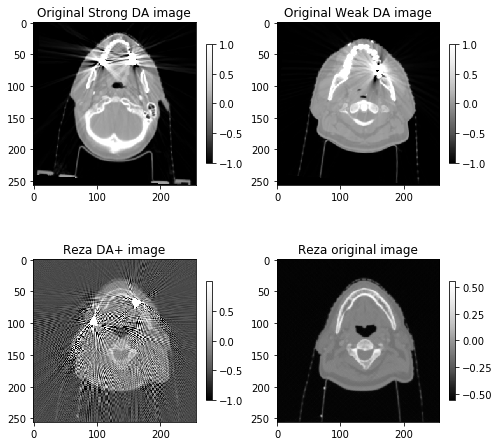

In [6]:
trg1X, trg1Y = trg_dataset[16]
val2X, val2Y = val_dataset[1]
val1X, val1Y = val_dataset[0]

cm = "Greys_r"

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[8, 8], facecolor='white')
img1 = ax[0,0].imshow(trg1X[0, 4, :, :], cmap=cm)
ax[0,0].set_title("Original Strong DA image")
fig.colorbar(img1, ax=ax[0,0], shrink=0.6)

img2 = ax[0,1].imshow(trg1Y[0, 4, :, :], cmap=cm)
ax[0,1].set_title("Original Weak DA image")
fig.colorbar(img2, ax=ax[0,1], shrink=0.6)

img3 = ax[1,0].imshow(val2X[0, 4, :, :], cmap=cm)
ax[1,0].set_title("Reza DA+ image")
fig.colorbar(img3, ax=ax[1,0], shrink=0.6)

img4 = ax[1,1].imshow(val2Y[0, 4, :, :], cmap=cm)
ax[1,1].set_title("Reza original image")
fig.colorbar(img4, ax=ax[1,1], shrink=0.6)

plt.show()

In [7]:
# Import module
from cycleGAN import GAN
checkpoint_path = "/cluster/home/carrowsm/logs/cycleGAN/8_256_256px/2-1/version_1/checkpoints/epoch=3.ckpt"
model = load_model(GAN, checkpoint_path)



In [ ]:
# Create some "clean" test images
val1_gen_y = model.g_y(val1X.unsqueeze(0).detach()).detach()
val2_gen_y = model.g_y(val2X.unsqueeze(0).detach()).detach()



In [ ]:
# Plot comparison between clean and original
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[8*2, 8], facecolor='white')

img = ax[0,0].imshow(val1Y[0, 4, :, :], cmap=cm)
ax[0,0].set_title("Image 1 - Original")
fig.colorbar(img, ax=ax[0,0], shrink=1)

img = ax[0,1].imshow(val1X[0, 4, :, :], cmap=cm)
ax[0,1].set_title("Image 1 - Reza DA+")
fig.colorbar(img, ax=ax[0,1], shrink=1)

img = ax[0,2].imshow(val1_gen_y[0, 0, 4, :, :].numpy(), cmap=cm)
ax[0,2].set_title("Image 1 - Generated DA-")
fig.colorbar(img, ax=ax[0,2], shrink=1)



img = ax[1,0].imshow(val2Y[0, 4, :, :], cmap=cm)
ax[1,0].set_title("Image 2 - Original")
fig.colorbar(img, ax=ax[1,0], shrink=1)

img = ax[1,1].imshow(val2X[0, 4, :, :], cmap=cm)
ax[1,1].set_title("Image 2 - Reza DA+")
fig.colorbar(img, ax=ax[1,1], shrink=1)

img = ax[1,2].imshow(val2_gen_y[0, 0, 4, :, :].numpy(), cmap=cm)
ax[1,2].set_title("Image 2 - Generated DA-")
fig.colorbar(img, ax=ax[1,2], shrink=1)

plt.show()

In [ ]:
# Check how many images can be used to test OAR segmentation
oar_df = pd.read_csv("../datasets/test_fold_oar_1.csv",usecols=["index", "0"],index_col="index")
gtv_df = pd.read_csv("../datasets/test_fold_gtv_1.csv",usecols=["index", "0"],index_col="index")
da_test_df = pd.read_csv("../datasets/test_labels.csv", dtype=str).set_index("patient_id")
da_train_df = pd.read_csv("../datasets/train_labels.csv", dtype=str).set_index("patient_id")

# Make column with MRN as index in each df
oar_df["mrn"] = oar_df.loc[:, "0"].str[-12:-5]
oar_df.set_index("mrn", inplace=True)
gtv_df["mrn"] = gtv_df.loc[:, "0"].str[-12:-5]
gtv_df.set_index("mrn", inplace=True)

In [ ]:
# da_train_df[da_train_df.index.isin(oar_df.index)]


In [ ]:
# common_gtv = da_test_df[da_test_df.index.isin(gtv_df.index)]
# common_oar = da_test_df[da_test_df.index.isin(oar_df.index)]
# full_da = pd.concat([da_train_df, da_test_df])

# full_oar = full_da[full_da.index.isin(oar_df.index)]
# full_oar.to_csv("../datasets/oar_segment_imgs.csv")

# full_gtv = full_da[full_da.index.isin(gtv_df.index)]
# full_gtv.to_csv("../datasets/gtv_segment_imgs.csv")

In [ ]:
# Load one image and plot centre
df = pd.read_csv("../datasets/oar_segment_imgs.csv", dtype=str).set_index("patient_id")
x_df2 = df[df["has_artifact"].isin(["2", "1"])] # Limit df to 'dirty' images
y_df2 = df[df["has_artifact"].isin(["0"])] # Limit df to 'dirty' images

# Define transforms to normalize input data
transform = torchvision.transforms.Compose([
                Normalize(-1000.0, 1000.0),
                ToTensor()])

# Initialize the dataloader
dataset = UnpairedDataset(x_df2, y_df2,
                      image_dir=img_dir,
                      cache_dir=os.path.join(cache_dir, "unpaired"),
                      file_type="DICOM",
                      image_size=[8, 256,256],
                      dim=3,
                      transform=transform,
                      num_workers=4)
x, y = dataset[0]
patient_id = dataset.x_ids[0]

In [ ]:
from data.preprocessing import resample_image, get_dicom_path, read_dicom_image
img_center_x = float(x_df2.at[patient_id, "img_center_x"])
img_center_y = float(x_df2.at[patient_id, "img_center_y"])
img_center_z = float(x_df2.at[patient_id, "img_center_z"])
coords = (img_center_x, img_center_y, img_center_z)

# Load full dicom
d_path = get_dicom_path(os.path.join(img_dir, patient_id))
img = read_dicom_image(d_path)
img_iso = resample_image(img, [1.0, 1.0, 1.0])

# Convert physical coords to isotropically-spaced index
ind = img_iso.TransformPhysicalPointToIndex(coords)


In [ ]:
print(img_iso.GetSize())
iso_slice = img_iso[:, :, ind[2]]
plt.figure()
plt.imshow(sitk.GetArrayFromImage(iso_slice))
plt.show()

In [ ]:
print(patient_id)